# AdventureWorks Försäljningsanalys

---


Beskriv kort vad analysen/projektet handlar om

## Setup

### Engine för att ansluta till SQL Servern

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

import os
from dotenv import load_dotenv

import numpy as np

load_dotenv()

user = os.getenv("user")
password = quote_plus(os.getenv("password"))
server = os.getenv("server")
database = os.getenv("database")
driver = quote_plus("ODBC Driver 18 for SQL Server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)

try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\josef\AppData\Local\Temp\ipykernel_4256\4253957184.py:28: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


Överblick, vad gör koden? 

1. Läser in konfigurationsvärden/variabler (user, password, server, database)
2. Skapar en databasanslutning baserat på dessa värden/variabler
3. Testar att anslutningen fungerar

Biblioteket sqlalchemy används i den här rapporten dels för databasanslutning (create_engine) och för SQL-körning (text). 

urllib.parse.quote_plus omvandlar specialtecken och mellanslag till tecken som fungerar i en URL.

pandas används för att läsa SQL-kod. 

För hantering av känsliga uppgifter så som lösenord används environment variables (miljövariabler). Då behövs biblioteken os och dotenv. 

os gör att programmet kan kommunicera med operativsystemet (överlag) och load_dotenv gör att miljövariablerna läses in i programmet från den separata text-filen. 

matplotlib används för att visualisera data.

### Hjälp-funktion för att läsa SQL-kod

In [3]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

I den här rapporten kommer det hämtas en hel del data från en databas. 

För att hålla allt fint och torrt (DRY, Don't Repeat Yourself) skapas en hjälpfunktion för att omvandla en SQL-query till en pandas DataFrame. 

Den här funktionen: 

- tar en SQL-query som text 
- öppnar en databasanslutning 
- kör query:n
- returnerar resultatet som en df
- stänger databasanslutningen 

## Visualiseringar

### Visualisering 1: Antal produkter per kategori

Affärsfråga: Hur många produkter finns i varje kategori?

Tabeller som används:

- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product

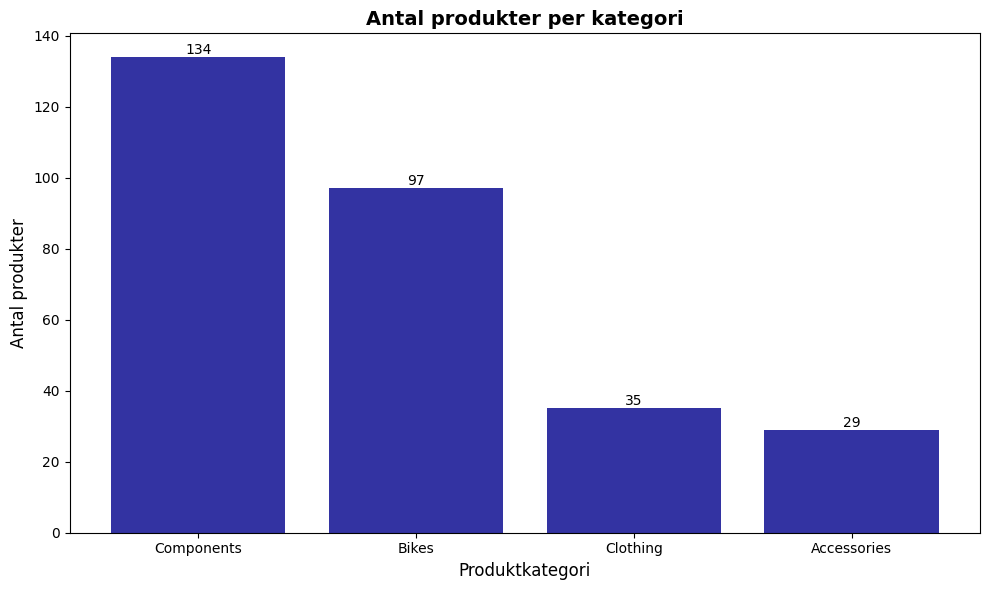

In [4]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(df_vis1["CategoryName"], df_vis1["ProductCount"], color="darkblue", alpha=0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

ax.set_xlabel("Produktkategori", fontsize=12)
ax.set_ylabel("Antal produkter", fontsize=12)
ax.set_title("Antal produkter per kategori", fontsize=14, fontweight="bold")

plt.tight_layout()

#### Insikter - Antal produkter per kategori

- Components är största kategorin med 134 produkter
- Accessories är minsta kategorin med 29 produkter 

Detta indikerar på att företaget är starkt fokuserat på komponenter och reservdelar. 

Komponenter utgör nästan mer än hälften av sortimentet. 

Accessoarer kan vara ett område där företaget kan utvecklas. 

##### Metod

- JOINA tabellerna 
    - Huvudtabellen är Production.ProductCategory för den ger produktkategorierna/namnen på produktkategorierna 
    - En produktkategori kan ha många underkategorier 
    - En produkt tillhör *en* underkategori
    - INNER JOIN används för att i just det här fallet är vi inte intresserade av produktkategorier som saknar produkter
- Räkna DISTINCT produkter per kategori
    - DISTINCT gör att vi inte får med eventuella dubletter (varje unik produkt räknas bara en gång)
- Skapa vertikalt stapeldiagram
    - en for-loop används för att skriva ut med klartext hur många produkter det finns i varje kategori 
        - for-loopen gör så att rätt text kopplas till rätt stapel
        - går också att använda ax.bar_label(bars, padding=3) (en inbyggd funktion, precis som exempelvis set_xlabel. padding säger hur högt ovanför stapeln texten ska placeras)
    - antalet produkter = höjden på stapeln 
    - ax.text ritar ut texten i diagrammet, på axeln 
    - texten placeras mha x och y-koordinater 
        - x &longrightarrow; mitten av stapeln, alltså staplens bredd / 2
        - y &longrightarrow; stapels höjd 
    - f"{int(height)}" = själva texten som ska skrivas ut 
    - ha och va bestämmer vilken del av texten som ska placeras på (x, y)
        - utan ha så förskjuts texten till höger 
        - utan va så hamnar texten alldeles för nära själva stapeln 
    - fontweight="bold" gör att titeln skrivs ut med fet text  
- Analysera resultatet

https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.bar_label.html#matplotlib.axes.Axes.bar_label

---

### Visualisering 2: Försäljning per produktkategori

Affärsfråga: Vad är den totala försäljningen för varje produktkategori? 

Tabeller som används: 

- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product
- Sales.SalesOrderDetail 

Total försäljning: 109 846 381.40 USD


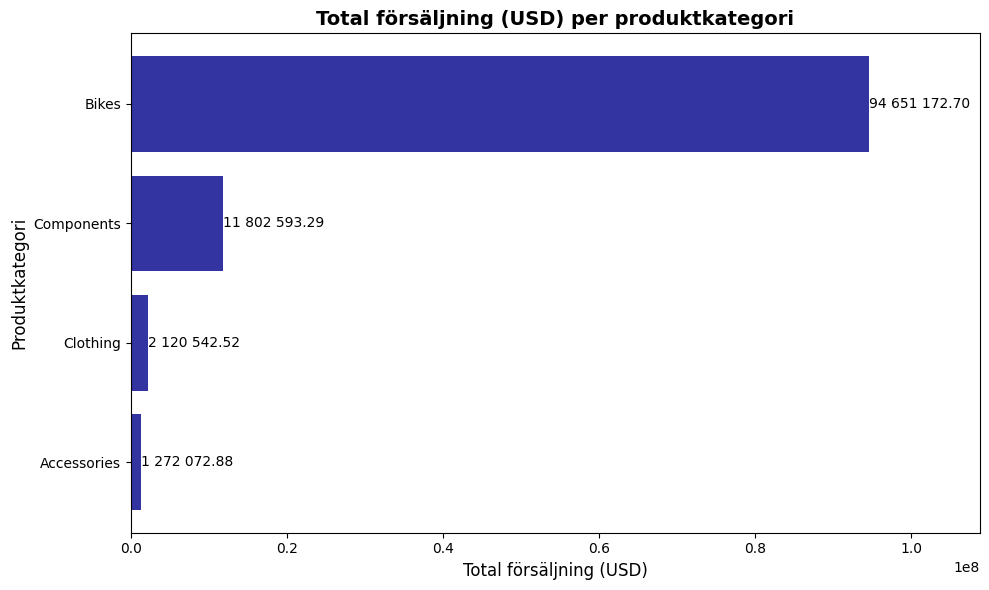

In [5]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalRevenue
FROM Sales.SalesOrderDetail AS sod
INNER JOIN Production.Product AS p ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory AS psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
INNER JOIN Production.ProductCategory AS pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY pc.Name
ORDER BY TotalRevenue ASC
"""

df_vis2 = query_df(query_vis2)

_, ax = plt.subplots(figsize=(10,6))

bars = ax.barh(df_vis2["CategoryName"], df_vis2["TotalRevenue"], color="darkblue", alpha=0.8)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"{width:,.2f}".replace(",", " "),
        va="center",
        ha="left"
    )

ax.set_xlabel("Total försäljning (USD)", fontsize=12)
ax.set_ylabel("Produktkategori", fontsize=12)
ax.set_title("Total försäljning (USD) per produktkategori", fontsize=14, fontweight="bold")
ax.set_xlim(0, df_vis2["TotalRevenue"].max() * 1.15)

plt.tight_layout()

query_vis2_2 = """
SELECT
    SUM(sod.LineTotal) AS TotalRevenue
FROM Sales.SalesOrderDetail AS sod
"""

df_vis2_2 = query_df(query_vis2_2)

total_revenue = df_vis2_2.iloc[0,0]

print(f"Total försäljning: {total_revenue:,.2f}".replace(",", " ") + " USD") 

#### Insikter - Försäljning per produktkategori

- Kategorin med störst försäljning är Bikes där total försäljning är 94 651 172,70 USD
- Kategorin med minst försäljning är Accessories där total försäljning är 1 272 072,88 USD 
- Intäkterna för Bikes utgör mer än 85 % av total försäljning och är den helt dominerande produktkategorin 
- Förändringar i produktkategorin Bikes har stor påverkan på den totala försäljningen

##### Metod:

- JOIN:a tabellerna (INNER JOIN - är bara intresserad av de kategorier med försäljning)
    - Huvudtabellen är Sales.SalesOrderDetail för där ligger försäljningen per orderrad 
    - Namnet på produktkategorierna finns i tabellen Production.ProductCategory och hämtas via Production.Product och Production.ProductSubcategory 
- Summera SalesOrderDetail.LineTotal per produktkategori 
    - Jag missade först att LineTotal fanns och beräknade försäljningen med OrderQty * UnitPrice
    - Men den beräkningen tog inte hänsyn till de få rader med rabatt 
    - Slutade vara blind och såg kolumnen LineTotal
- Kontrollera vilken valuta LineTotal är 
    - Finns ingen information om valuta i Sales.SalesOrderDetail, men det går att söka efter tabeller som innehåller ett specifikt nyckelord med en liten fiffig query: 

        ```sql
        SELECT
            TABLE_SCHEMA,
            TABLE_NAME
        FROM INFORMATION_SCHEMA.TABLES
        WHERE TABLE_NAME LIKE '%Currency%'
        ```
    - Resultatet blev:
        - Sales.CountryRegionCurrency
            - ger CountryRegionCode och motsvarande CurrencyCode &longrightarrow; inte av intresse
        - Sales.Currency
            - ger CurrencyCode och motsvarande namn på valutan &longrightarrow; inte av intresse
        - Sales.CurrencyRate
            - ger FromCurrencyCode och ToCurrencyCode &longrightarrow; intressant 
    - FromCurrencyCode är alltid USD &longrightarrow; AdventureWorks valuta? 
    - Antar utifrån detta att all försäljning sparas som USD
- Skapa horisontellt stapeldiagram 
    - här används samma for-loop igen, men här "byter x och y plats" 
        - värdet vi vill skriva ut = bredden på stapeln (width) 
    - I uppgiftsbeskrivningen står det att insikten/analysen ska göras med *exakta siffror*
        - int(width) tar bort decimalerna och då får vi ju inte ett *exakt* värde så jag plockade bort int()
        - men 5 decimaler kändes lite overkill så jag lade till formateringen .2f 
        - eftersom försäljningssiffrorna var så stora var de lite svåra att läsa, men precis som med .2f så finns det en formatering som gör att tal skrivs ut med tusentalsavskiljare :,
        - grundutförandet av :, är att varje tusental avskiljs med ett kommatecken, men det går att byta ut till mellanslag mha replace(",", " ")
    - texten vid den största stapeln hamnade utanför diagrammet, vilket såg jättefult ut 
        - men som tur är så finns det en funktion som gör att man kan modda x-axeln 
        - i just det här fallet görs x-axeln längre
            - x-axeln ska börja på 0 och sluta vid 115 % av det största värdet (= df_vis2["TotalRevenue"].max())
    - Ändra från DESC till ASC i sql-queryn för det gjorde att den största stapeln hamnade överst
- Analysera resultatet
    - Beräknade den totala försäljningen med en enkel query för att kunna konstatera hur stor andel av försäljningen som kommer från kategorin "Bikes" 
    - Uträknad total försäljning hamnar ju i en DataFrame (med en kolumn och en rad) och för att kunna skriva ut värdet med en f-string hämtas det från df:en med hjälp av .iloc och sparas i en variabel 

https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlim.html#matplotlib.axes.Axes.set_xlim

---

### Visualisering 3: Försäljningstrend över tid

Affärsfråga: Hur har försäljningen utvecklats över tid? 

Tabeller som används:

* Sales.SalesOrderHeader

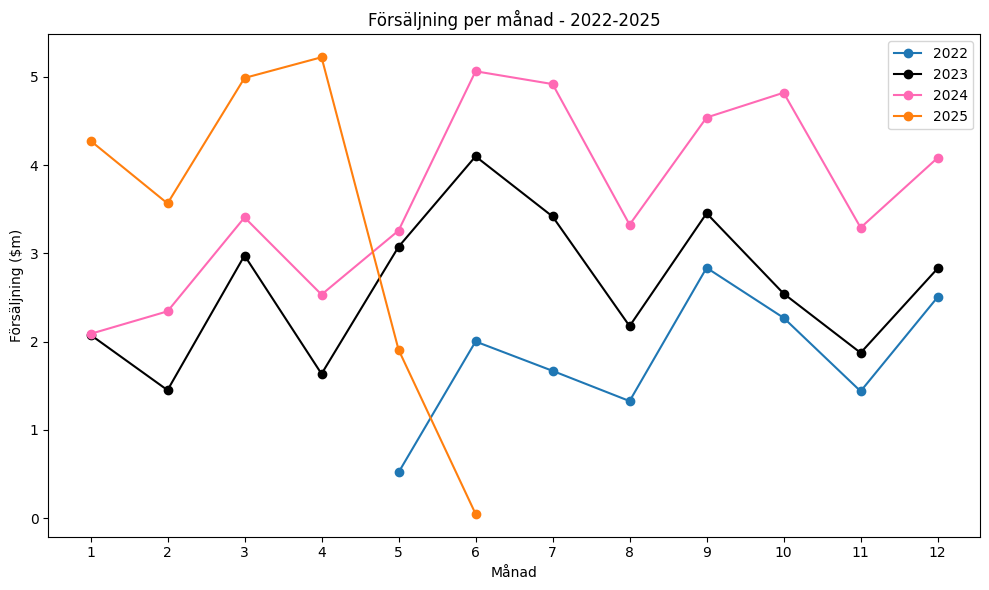

In [6]:
query_vis3_2022 = """
SELECT
    MONTH(soh.OrderDate) AS OrderMonth,
    SUM(soh.SubTotal) AS TotalRevenue    
FROM Sales.SalesOrderHeader AS soh
WHERE soh.OrderDate >= '2022-01-01'
    AND soh.OrderDate < '2023-01-01'
GROUP BY 
    MONTH(soh.OrderDate)
ORDER BY 
    OrderMonth
"""

query_vis3_2023 = """
SELECT
    MONTH(soh.OrderDate) AS OrderMonth,
    SUM(soh.SubTotal) AS TotalRevenue    
FROM Sales.SalesOrderHeader AS soh
WHERE soh.OrderDate >= '2023-01-01'
    AND soh.OrderDate < '2024-01-01'
GROUP BY 
    MONTH(soh.OrderDate)
ORDER BY 
    OrderMonth
"""

query_vis3_2024 = """
SELECT
    MONTH(soh.OrderDate) AS OrderMonth,
    SUM(soh.SubTotal) AS TotalRevenue    
FROM Sales.SalesOrderHeader AS soh
WHERE soh.OrderDate >= '2024-01-01'
    AND soh.OrderDate < '2025-01-01'
GROUP BY 
    MONTH(soh.OrderDate)
ORDER BY 
    OrderMonth
"""

query_vis3_2025 = """
SELECT
    MONTH(soh.OrderDate) AS OrderMonth,
    SUM(soh.SubTotal) AS TotalRevenue    
FROM Sales.SalesOrderHeader AS soh
WHERE soh.OrderDate >= '2025-01-01'
    AND soh.OrderDate < '2026-01-01'
GROUP BY 
    MONTH(soh.OrderDate)
ORDER BY 
    OrderMonth
"""

df_vis3_2022 = query_df(query_vis3_2022)
df_vis3_2023 = query_df(query_vis3_2023)
df_vis3_2024 = query_df(query_vis3_2024)
df_vis3_2025 = query_df(query_vis3_2025)

plt.figure(figsize=(10,6))

plt.plot(df_vis3_2022["OrderMonth"], df_vis3_2022["TotalRevenue"] / 1_000_000, marker="o", label="2022")
plt.plot(df_vis3_2023["OrderMonth"], df_vis3_2023["TotalRevenue"] / 1_000_000, marker="o", label="2023", color="black")
plt.plot(df_vis3_2024["OrderMonth"], df_vis3_2024["TotalRevenue"] / 1_000_000, marker="o", label="2024", color="hotpink")
plt.plot(df_vis3_2025["OrderMonth"], df_vis3_2025["TotalRevenue"] / 1_000_000, marker="o", label="2025")

plt.xlabel("Månad")
plt.ylabel("Försäljning ($m)")
plt.title("Försäljning per månad - 2022-2025")
plt.xticks(range(1,13))
plt.legend()
plt.tight_layout()

#### Insikter - Försäljningstrend över tid

- Försäljningen har ökat varje år 
- Försäljningsmönstret ser liknande ut under åren 2023-2024 med en försäljningstopp i juni
    - Med verksamhet på norra halvklotet är det rimligt att försäljning av cyklar ökar under tidig sommar och på hösten då vädret är lämpligast för cykelturer
- Månader med lägst försäljning skiljer sig lite från år till år, men 2023 var februari den månad med lägst försäljning och 2024 var det januari
    - Överlag är försäljningen lägre under vintermånaderna, för att öka något runt årskiften (kanske på grund av nyårslöften?)
- 2025 skiljer sig åt från tidigare år
    - total försäljning ökade markant i början av året jämfört med 2024
    - mellan mars och april ökade försäljningen, vilket inte har hänt under tidigare år
    - försäljningen slår rekord i april 2025 för att sedan dyka rejält och gå emot tidigare trender 
- Den månad med absolut lägst försäljning är juni 2025 

AdventureWorks rekommenderas att undersöka vidare varför försäljningen störtdök efter april 2025. Är datan komplett? Var det utförsäljning under våren 2025 för att ge plats åt nytt sortiment? Vad har hänt?


##### Metod

- Hur ser tabellen Sales.SalesOrderHeader ut? 
    - Finns både SubTotal och TotalDue 
    - Räknar ut att SubTotal är samma som SalesOrderDetail.LineTotal
    - Men TotalDue är SubTotal + TaxAmt + Freight (alltså skattepåslag och kostnad för frakt)
    - Jag väljer att använda mig av SubTotal för skatten är inte en intäkt som AdventureWorks får och det är bäst att använda samma siffror som i uppgiften innan 
- Mellan vilka datum sträcker sig datan? 
    - 2022-05-30 till 2025-06-29
    - Alltså 2 hela år (2023 och 2024) och två halva år (2022 och 2025)
- Jag beslutar mig för att ta ut försäljningssiffrorna per månad och per år och presentera resultatet i ett linjediagram med en linje för varje år 
    - plockar ut månad från OrderDate med Month()
    - beräknar försäljningen med SUM()
    - filtrerar på aktuellt år med WHERE 
    - gör en query för varje år
- Jag upptäcker att försäljningen i juni 2025 är otroligt låg
    - Kontrollerar att det har lagts ordrar även i slutet av månaden
    - Räknar antalet ordrar från juni 2025 och jämför med andra månader
        - ser inget konstigt 
- Skapar linjediagram
    - att skapa linjediagram kräver inga speciella funktioner som med stapeldiagram (bar) eller histogram (hist), utan x- och y-värden plottas direkt
    - x- och y-värdena hämtas i DataFrames:en där x är OrderMonth och y är TotalRevenue 
    - TotalRevenue delas med 1 000 000 för att y-axeln ska se snyggare ut (finns ingen anledning att visa som miljoner då alla försäljningssiffror är stora tal)
    - plt.xticks(range(1, 13)) används för att det ska bli en "prick" på varje månad, inte bara varannan

##### Förbättringar

- Skapa någon typ av loop-situation som gör att det inte behöver upprepas så mycket text/kod

---

### Visualisering 4: Försäljning & antal ordrar per år

Affärsfråga: Hur ser total försäljning och antal ordrar ut per år?

Tabeller som används:

- Sales.SalesOrderHeader

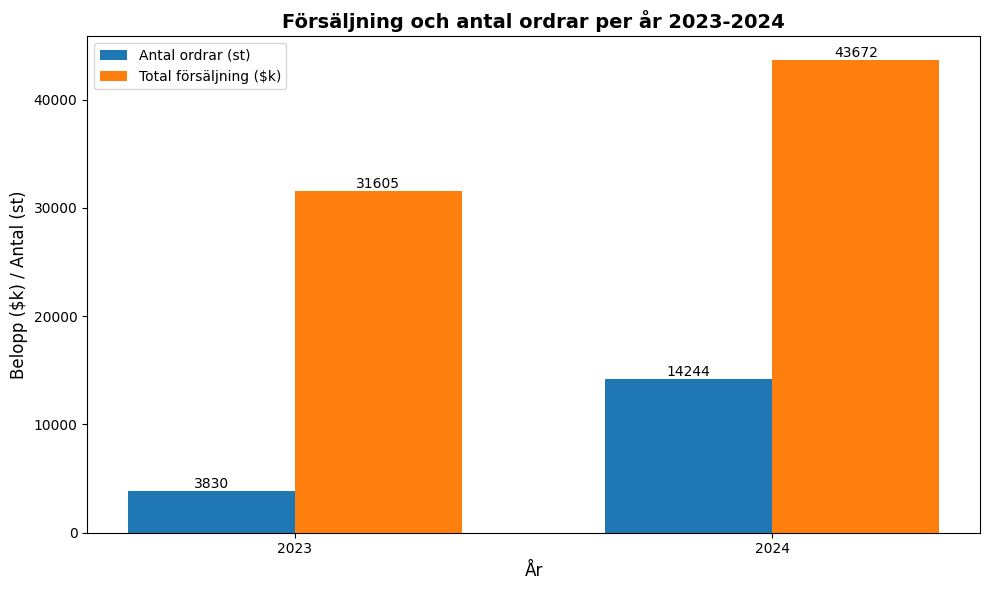

In [19]:
query_vis4 = """
SELECT
    YEAR(soh.OrderDate) AS OrderYear,
    COUNT(*) AS OrderCount,
    SUM(soh.SubTotal) AS TotalRevenue
FROM Sales.SalesOrderHeader AS soh
WHERE OrderDate >= '2023-01-01' AND OrderDate < '2025-01-01'
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear
"""

df_vis4 = query_df(query_vis4)

x = np.arange(len(df_vis4))
width = 0.35

_, ax = plt.subplots(figsize=(10,6))

bars_orders = ax.bar(
    x - width / 2,
    df_vis4["OrderCount"],
    width,
    label="Antal ordrar (st)",
)

bars_revenue = ax.bar(
    x + width / 2,
    df_vis4["TotalRevenue"] / 1_000,
    width,
    label="Total försäljning ($k)",
)

for bars in [bars_orders, bars_revenue]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.0f}",
            ha="center",
            va="bottom"
        )

ax.set_xticks(x)
ax.set_xticklabels(df_vis4["OrderYear"])
ax.set_xlabel("År", fontsize=12)
ax.set_ylabel("Belopp ($k) / Antal (st)", fontsize=12)
ax.set_title("Försäljning och antal ordrar per år 2023-2024", fontsize=14, fontweight="bold")
ax.legend()

plt.tight_layout()

In [16]:
df_vis4["AOV"] = df_vis4["TotalRevenue"] / df_vis4["OrderCount"]

print(f"Genomsnittligt ordervärde för 2023: {df_vis4["AOV"].iloc[0]:.2f} $")
print(f"Genomsnittligt ordervärde för 2024: {df_vis4["AOV"].iloc[1]:.2f} $")

Genomsnittligt ordervärde för 2023: 8251.94 $
Genomsnittligt ordervärde för 2024: 3065.98 $


#### Insikter - Försäljning & antal ordrar per år

- Både intäkt och antal ordrar ökade från 2023 till 2024 
- Intäkten ökade med nästan 40 % år 2024 jämfört med 2023
- Antalet ordrar ökade med 270 % år 2024 jämfört med 2023 
- Det genomsnittliga ordervärdet (AOV) sjönk kraftigt under 2024
    - Från 8200 \$ 2023 till 3000 \$ 2024, vilket motsvarar en minskning på över 60 %
- Vi har sett tidigare i rapporten att AdventureWorks har en stort sortiment av komponenter och reservdelar. Att AOV sjönk så mycket under 2024, men att både försäljning och antal ordrar ökade kan indikera på att det var just den här produktkategorin, Compontens, som utgjorde en stor del av försäljningen under 2024 (då komponenter och reservdelar kostar mindre än en hel cykel) 

##### Metod

- Varje rad i Sales.SalesOrderHeader är en order 
- Räknar antalet rader med COUNT()
- Beräknar total försäljning med SUM() på SalesOrderHeader.SubTotal
- Filtrerar på år 2023 och 2024 då de är de enda åren som är kompletta 
- Skapa en grouped bar chart 
    - skillnaden mellan en vanlig bar chart och en grouped bar chart är att det är två värden för varje kategori på x-axeln (i det här fallet är 2023 och 2024 kategorierna och värdena (staplarna) är ordrar och försäljning)
    - Kruxet är att placera staplarna så att de inte hamnar rakt på varandra, utan förskjuts så de hamnar precis bredvid varandra 
    - np.arange(len(df_vis4)) ger en array, [0, 1], kategorierna på x-axeln blir alltså numeriska, 2023 = 0 och 2024 = 1
    - kategorierna behöver göras om till numeriska värden för att de ska kunna användas i beräkningar
    - varje stapel ritas ut genom att beräkna positionen i förhållande till 0 och 1, dvs x ± bredden på stapeln / 2 
    - ax.bar() ritar ut två staplar för att y = df_vis4["OrderCount"] innehåller två värden 
    - Försäljningen (TotalRevenue) skalas om genom att divideras med 1000 för att y-axeln ska få en mer rimlig skala som passar både försäljning och antal ordrar
    - Eftersom 2023 och 2024 har blivit 0 och 1 (vilket inte säger mycket) döps de om/tillbaka till 2023 och 2024 med ax.set_xtickslabels
    - for-loopen för att placera text uppepå staplarna får "byggas om" till en inre och yttre loop. 
        - den yttre loopen "väljer" först order-staplarna och sedan försäljnings-staplarna
        - den inre loopen är den "som arbetar" och faktiskt skriver ut texten
- Analysera resultatet 
    - Beräkna AOV

https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

---

### Visualisering 5: Top 10 produkter 

Affärsfråga: Vilka 10 produkter genererar mest försäljning? 

Tabeller som används: 

- Production.Product
- Sales.SalesOrderDetail

In [26]:
query_vis5 = """
SELECT TOP 10
    p.Name AS ProduktNamn,
    pc.Name AS Kategori,
    psc.Name AS Underkategori, 
    SUM(sod.LineTotal) AS TotalFörsäljning
FROM Production.Product AS p
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID
LEFT JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
LEFT JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY p.Name, pc.Name, psc.Name 
ORDER BY TotalFörsäljning DESC
"""

df_vis5 = query_df(query_vis5)

In [27]:
df_vis5

,ProduktNamn,Kategori,Underkategori,TotalFörsäljning
0,"Mountain-200 Black, 38",Bikes,Mountain Bikes,4.400593e+06
1,"Mountain-200 Black, 42",Bikes,Mountain Bikes,4.009495e+06
2,"Mountain-200 Silver, 38",Bikes,Mountain Bikes,3.693678e+06
3,"Mountain-200 Silver, 42",Bikes,Mountain Bikes,3.438479e+06
4,"Mountain-200 Silver, 46",Bikes,Mountain Bikes,3.434257e+06
5,"Mountain-200 Black, 46",Bikes,Mountain Bikes,3.309673e+06
6,"Road-250 Black, 44",Bikes,Road Bikes,2.516857e+06
7,"Road-250 Black, 48",Bikes,Road Bikes,2.347656e+06
8,"Road-250 Black, 52",Bikes,Road Bikes,2.012448e+06
9,"Road-150 Red, 56",Bikes,Road Bikes,1.847819e+06


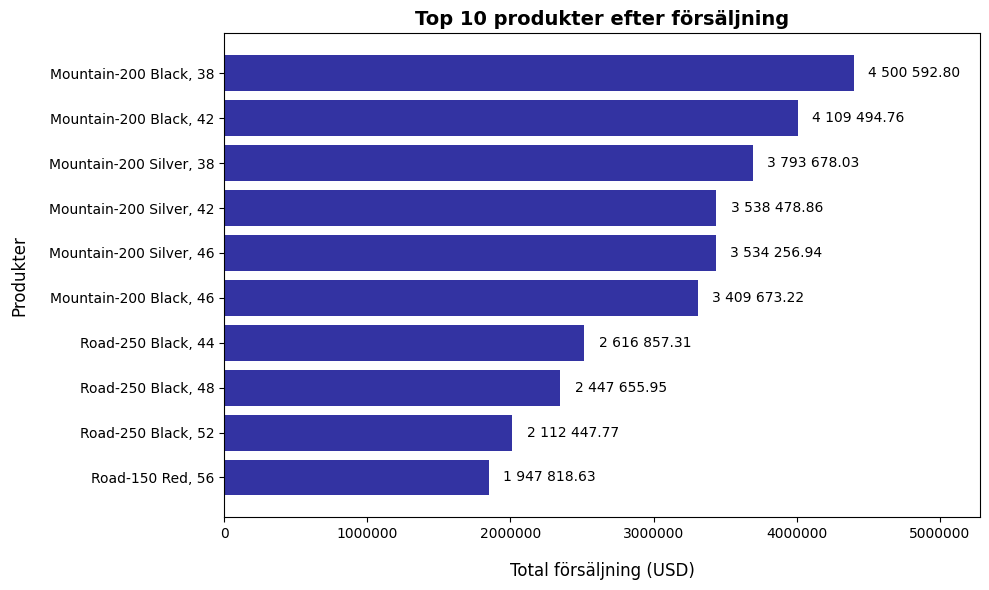

In [40]:
_, ax = plt.subplots(figsize=(10,6))

bars = ax.barh(df_vis5["ProduktNamn"], df_vis5["TotalFörsäljning"], color="darkblue", alpha=0.8)

for bar in bars:
    width = bar.get_width() + 100_000
    ax.text(
        width,
        bar.get_y() + bar.get_height() / 2, 
        f"{width:,.2f}".replace(",", " "),
        va="center",
        ha="left"
    )

ax.set_xlabel("Total försäljning (USD)", fontsize=12, labelpad=15)
ax.set_ylabel("Produkter", fontsize=12, labelpad=15)
ax.set_title("Top 10 produkter efter försäljning", fontsize=14, fontweight="bold")
ax.set_xlim(0, df_vis5["TotalFörsäljning"].max() * 1.20)
ax.invert_yaxis()
ax.ticklabel_format(axis="x", style="plain", )

plt.tight_layout()


#### Insikter - Top 10 produkter

- Produkten som genererar högst försäljning (4 400 592,80 USD) är Mountain-200 Black 38, vilket är en mountain bike
- Samtliga produkter i top 10-listan tillhör kategorin Bikes 
- Den dominerande underkategorin är Mountain Bikes där top 1-6 är mountain bikes 

##### Metod

- Huvudtabellen är Production.Product för i den finns namnet på produkterna 
- JOIN:ar på (INNER JOIN) Sales.SalesOrderDetail på Production.Product 
    - INNER JOIN för vi är inte intresserade av produkter utan försäljning
- Avgränsar resultatet till 10 med TOP 10
- Beräknar total försäljning med SUM() på LineTotal 
- Uppgiften efterfrågar om det finns någon specifik kategori som "dominerar" i top 10-listan och även om det går att anta utifrån produktnamnen så väljer jag att hämta både kategori och underkategori
    - Detta gör jag genom att JOIN:a på Production.ProductSubcategory och Production.ProductCategory på Production.Product
    - LEFT JOIN för att få med eventuella produkter som inte tillhör en kategori eller underkategori
- DESC för att få top 10 produkterna med högst försäljning 
- Jag väljer att skriva ut DataFrame:n som en tabell för att det ska bli tydligt vilka kategorier och underkategorier som produkterna tillhör 
- Skapa ett horisontellt stapeldiagram 
    - samma metod som med tidigare vertikala och horisontella stapeldiagram, men med några ändringar/finjusteringar:
        - jag ville att texten bredvid varje stapel skulle hamna lite längre ifrån själva stapeln 
            - detta går att ordna genom att "göra" stapeln 100 000 större (alltså bar.get_width() + 100_000)
            - x-postionen = där staplen slutar, alltså hur stor stapeln är 
            - är stapeln större hamnar texten längre bort 
        - jag tyckte att titlarna på axlarna hamnade för nära axel-"ticks:en" (alltså produkterna och skalan på x-axeln), men detta går att justera med labelpad
    - Utökade x-axeln med ytterligare 5 % (från 1.15 till 1.20) pga att jag flyttade stapel-texterna längre åt höger 
    - uppgiften krävde att den största stapeln skulle ritas överst 
        - gick inte att ändra från DESC till ASC i sql-queryn (som i uppgift 2) för då får man top 10 produkter med lägst försäljning (lol)
        - men såklart finns det en funktion som byter ordning på staplarna: inver_yaxis()
    - default på axlarna är att stora tal skrivs ut som exponenter, vilket gör att det på t ex x-axeln står 1e6 
        - för att göra diagrammet ännu tjusigare genom att ta bort 1e6 valde jag att med ticklabel_format() ändra från default "scientific" till "plain"  

https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.ticklabel_format.html#matplotlib.axes.Axes.ticklabel_format


---

### Visualisering 6: Försäljning & antal kunder per region

Affärsfråga: Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

Tabeller som används:

- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer 

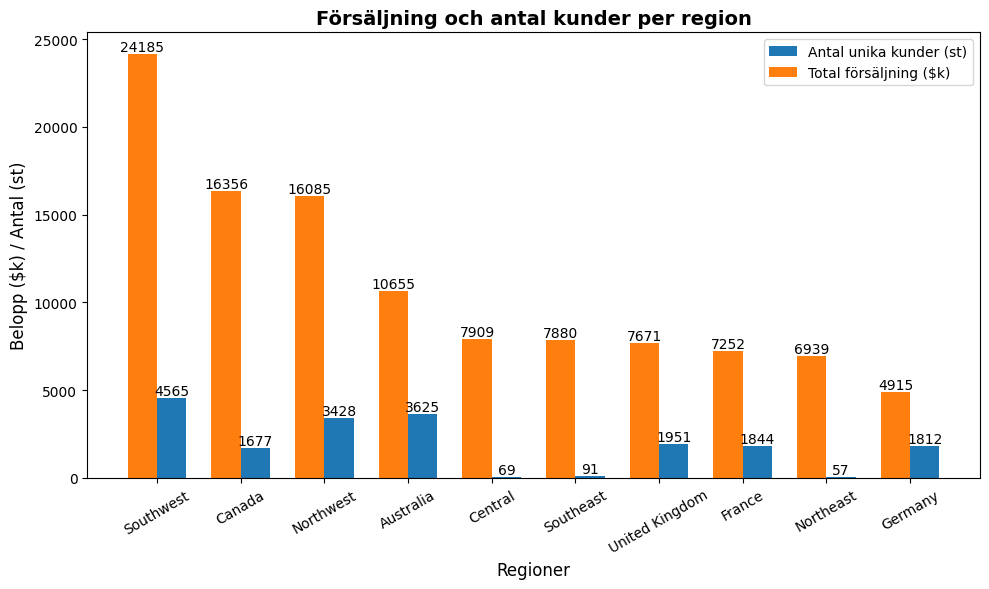

In [89]:
query_vis6 = """
SELECT 
    st.Name AS Region,
    SUM(soh.SubTotal) AS TotalFörsäljning,
    COUNT(DISTINCT soh.CustomerID) AS AntalKunder
FROM Sales.SalesTerritory AS st
INNER JOIN Sales.Customer c ON st.TerritoryID = c.TerritoryID
INNER JOIN Sales.SalesOrderHeader soh ON c.CustomerID = soh.CustomerID
GROUP BY st.Name
ORDER BY TotalFörsäljning DESC
"""

df_vis6 = query_df(query_vis6)

x = np.arange(len(df_vis6))
width = 0.35

_, ax = plt.subplots(figsize=(10,6))

bars_customers = ax.bar(
    x + width / 2,
    df_vis6["AntalKunder"],
    width,
    label="Antal unika kunder (st)",
)

bars_revenue = ax.bar(
    x - width / 2,
    df_vis6["TotalFörsäljning"] / 1_000,
    width,
    label="Total försäljning ($k)",
)

for bars in [bars_customers, bars_revenue]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.0f}",
            ha="center",
            va="bottom"
        )

ax.set_xticks(x)
ax.set_xticklabels(df_vis6["Region"], rotation=30)
ax.set_xlabel("Regioner", fontsize=12)
ax.set_ylabel("Belopp ($k) / Antal (st)", fontsize=12)
ax.set_title("Försäljning och antal kunder per region", fontsize=14, fontweight="bold")
ax.legend()

plt.tight_layout()

In [77]:
df_vis6["AOV_per_Customer"] = df_vis6["TotalFörsäljning"] / df_vis6["AntalKunder"]

print("Genomsnittligt ordervärde per kund i:")
print(f"Southwest: {df_vis6["AOV_per_Customer"].iloc[0]:.2f} $")
print(f"Canada: {df_vis6["AOV_per_Customer"].iloc[1]:.2f} $")
print(f"Northwest: {df_vis6["AOV_per_Customer"].iloc[2]:.2f} $")

display(df_vis6)

Genomsnittligt ordervärde per kund i:
Southwest: 5297.83 $
Canada: 9752.99 $
Northwest: 4692.22 $


,Region,TotalFörsäljning,AntalKunder,AOV_per_Customer
0,Southwest,2.418461e+07,4565,5297.833428
1,Canada,1.635577e+07,1677,9752.993712
2,Northwest,1.608494e+07,3428,4692.223614
3,Australia,1.065534e+07,3625,2939.403023
4,Central,7.909009e+06,69,114623.318930
5,Southeast,7.879655e+06,91,86589.616188
6,United Kingdom,7.670721e+06,1951,3931.686846
7,France,7.251556e+06,1844,3932.513909
8,Northeast,6.939374e+06,57,121743.411953
9,Germany,4.915408e+06,1812,2712.697349


#### Insikter - Försäljning och antal kunder per region

- Regionen med störst försäljning är Southwest. 
    - Southwest har nästan 50 % högre försäljning än regionerna som ligger på andra och tredje plats (Canada och Northwest)
- Southwest har också fler unika kunder jämfört med Canada och Northwest (170 % fler än Canada och 30 % fler än Northwest)
- Canada har högst ordervärde per kund bland top 3 regionerna med högst försäljning - mycket färre unika kunder än både Southwest och Northwest, men samma försäljning som Northwest och top 2 bland alla regioner
- Men regionerna med lägst antal kunder, Northeast, Central och Southeast, är också de regioner med allra högst ordervärde per kund
    - Att skillnaden i AOV mellan regionerna med högst försäljning och regionerna med lägst antal kunder är så otroligt stor kan tyda på att de flesta kunder i Northeast, Central och Southeast är företagskunder och inte privatpersoner
- Den svagast regionen med lägst försäljning är Germany 
    - Germany har nästan 30 % lägre försäljning än regionen som är näst svagast: Northeast

##### Metod

- Huvudtabellen är Sales.SalesTerritory för där finns namnen på regionerna 
- Använder INNER JOIN för att join:a på Sales.Customer och Sales.SalesOrderHeader (är bara intresserad av regioner där det har skett en försäljning)
- TerritoryID finns i Sales.SalesOrderHeader så Sales.Customer-tabellen behövs egentligen inte, men valde att join:a på den ändå för att träna
- Jag räknar antalet unika kunder med COUNT() och DISTINCT() på CustomerID 
- Skapa en grouped bar chart
    - precis samma metod som med tidigare grouped bar chart
- Analysera resultatet
    - Väljer att skapa en helper column i DataFrame:n - AOV_per_Customer för att kunna plocka ut och se genomsnittligt ordervärde per kund för de olika regionerna

#### Förbättringar 

- Rita diagrammet med två y-axlar då enheterna för försäljning resp. antal kunder är så olika stora 
- Göra så att texten ovanför den lägre stolpen flyttas lite åt höger så den inte cuttar in i stapeln bredvid

---

### Visualisering 7: Genomsnittligt ordervärde per region och kundtyp

Affärsfråga: Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder? 

Tabeller som används:

- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer
- Sales.Store

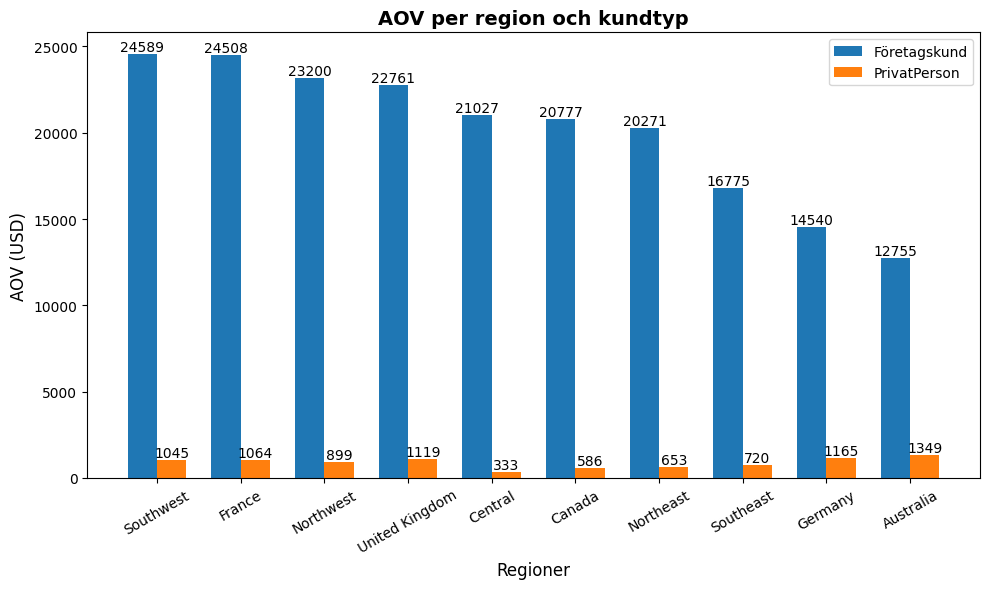

In [98]:
query_vis7 = """
SELECT
    st.Name AS Region,
    CASE 
        When c.StoreID IS NOT NULL THEN 'Företagskund'
        ELSE 'PrivatPerson'
    END AS Kundtyp,
    SUM(soh.SubTotal) AS TotalFörsäljning,
    COUNT(DISTINCT soh.SalesOrderID) AS AntalOrdrar,
    SUM(soh.SubTotal) / COUNT(DISTINCT soh.SalesOrderID) AS AOV
FROM Sales.SalesTerritory AS st
INNER JOIN Sales.Customer c ON st.TerritoryID = c.TerritoryID
INNER JOIN Sales.SalesOrderHeader soh ON c.CustomerID = soh.CustomerID
GROUP BY 
    st.Name,
    CASE WHEN c.StoreID IS NOT NULL THEN 'Företagskund' ELSE 'PrivatPerson' END
ORDER BY Region, Kundtyp
"""

df_vis7 = query_df(query_vis7)

df_vis7_pivot = df_vis7.pivot(index="Region", columns="Kundtyp", values="AOV")

df_vis7_pivot = df_vis7_pivot.sort_values("Företagskund", ascending=False)

x = np.arange(len(df_vis7_pivot))
width = 0.35

_, ax = plt.subplots(figsize=(10,6))

bars_store = ax.bar(
    x - width / 2,
    df_vis7_pivot["Företagskund"],
    width,
    label="Företagskund",
)

bars_person = ax.bar(
    x + width / 2,
    df_vis7_pivot["PrivatPerson"],
    width,
    label="PrivatPerson",
)

for bars in [bars_store, bars_person]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.0f}",
            ha="center",
            va="bottom"
        )

ax.set_xticks(x)
ax.set_xticklabels(df_vis7_pivot.index, rotation=30)
ax.set_xlabel("Regioner", fontsize=12)
ax.set_ylabel("AOV (USD)", fontsize=12)
ax.set_title("AOV per region och kundtyp", fontsize=14, fontweight="bold")
ax.legend()

plt.tight_layout()

#### Insikter - Genomsnittligt ordervärde per region och kundtyp

##### Metod

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html#pandas.DataFrame.pivot